## Figuring out which hospitals are following the price transparency laws

We're going to do a quick-and-dirty analysis of hospital chargemasters. It's reminiscent of my earlier work, but probably more accurate.

> Disclaimer! Compliance is a nuanced issue. This isn't a perfect compliance checker, nor is it able to check whether the rows in the files actually have the right prices (or even make sense!) It's looking at the file metadata to see which values are in them. This data is just a quick test to replicate and improve on existing work on hospital compliance.

## Known Issues
* Many `.head()` requests are failing for some reason
* Content reads are failing for some reason
* Lots of reads are timing out in `get_chunk()`, during `r.read()` and `r.json()`. Why?

### Downloading the Dolt database and reading in the data

In [2]:
%%capture
!sudo curl -L https://github.com/dolthub/dolt/releases/latest/download/install.sh | sudo bash
!pip install polars
!pip install --upgrade pandas
!pip install --upgrade xlrd
!pip install pyxslb
!dolt clone onefact/paylesshealth
!cd paylesshealth && dolt table export hospitals hospitals.csv

In [2]:
import aiohttp
import asyncio
import re
import cgi
import zipfile
import io
import json
import traceback
import logging
log = logging.getLogger(__name__)
import warnings
import requests
requests.packages.urllib3.disable_warnings() 

import polars     as pl
import pandas     as pd
import openpyxl

from io           import BytesIO
from glob         import glob
from pathlib      import Path
from urllib.parse import urlparse

In [3]:
def read_data(filename: str) -> pl.DataFrame:
    df = pl.read_csv(filename, infer_schema_length = 0)
    return (df.with_column(
        pl.col('cdm_url').str.split('|').alias('split_urls')
    ))

In [4]:
df = read_data('paylesshealth/hospitals.csv')

In [5]:
frac_null = 100*len(df.filter(pl.col("cdm_url").is_null()))//len(df)
print(f'{frac_null}% of our hospitals are missing their price list')

25% of our hospitals are missing their price list


## Pulling in the JAMA study data


We'll also add a column to our dataframe to compare our study to [this hospital compliance study from JAMA](https://jamanetwork.com/journals/jama-health-forum/fullarticle/2793645)) (the data is here: https://www.yunanji.com/data
https://www.yunanji.com/data)

In [6]:
study_url= 'https://scholar.harvard.edu/files/ekong/files/ji_kong_2022_price_transparency_compliance_data.csv'
df_2 = pl.read_csv(study_url, dtypes = {'ccn': str})
df_2 = df_2.select(['ccn', 'compliance']).rename({'compliance': 'jama_compliance'})
df_2.head()

ccn,jama_compliance
str,i64
"""010001""",1
"""010005""",0
"""010006""",1
"""010007""",0
"""010008""",0


In [7]:
df = df.join(df_2, on = 'ccn', how = 'outer')

### A quick check -- reproducible science

Do the hospitals which are marked as compliant have URLs in our database?

In [8]:
v1 = len(df.filter(pl.col('jama_compliance') == 1).filter(pl.col('cdm_url').is_null()))
print(f"""There are {v1} hospitals marked as compliant in the original JAMA article which we don't have URLs for.""")

v2 = len(df.filter(pl.col('jama_compliance') == 0).filter(pl.col('cdm_url').is_not_null()))
print(f"""There are {v2} hospitals marked as non-compliant in the original JAMA article which we DO have URLs for.""")

There are 319 hospitals marked as compliant in the original JAMA article which we don't have URLs for.
There are 1076 hospitals marked as non-compliant in the original JAMA article which we DO have URLs for.


We'll see how many of those non-compliant hospitals end up non-compliant in our later analysis.

In [9]:
# this part splits URLs which are like
# url1|url2
# into different rows
df = (df.explode(pl.col('split_urls'))
      .drop('cdm_url')
      .rename({'split_urls':'cdm_url'}))

### Machine-readable files

The price lists are required to be machine-readable. We'll look for extensions that match that requirement.

In [10]:
#.ashx is currently an odd one, but usually returns a csv
excel_exts = ['.xls', '.xlsx', '.xlsm', '.xlsb']
text_exts  = ['.csv', '.txt', '.xml', '.json', '.ashx']
zip_exts   = ['.zip']

mrf_exts = excel_exts + text_exts + zip_exts

### Checking compliance with simple functions

We're checking compliance based on the rules here:

https://www.federalregister.gov/d/2019-24931/p-1010https://www.federalregister.gov/d/2019-24931/p-1010

Our main tool is a blunt one: whether one string is in another.


In [11]:
def isin(chunk: str, *args) -> bool:
    "checks if any of args are in the chunk"
    return any([s in chunk for s in args])

assert isin('apple', 'a')
assert isin('Peter Piper picked a peck', *['Peter', 'randomstring'])

### The strategy: string-matching on the first little bit of each file

The functions defined below check a chunk of text to see if that chunk contains complaince information. (The function `filename_check()` is a special case: it checks whether the name of the file is compliant with the legal guidelines.)

What we do is download a little bit of each file (Excel and tree-like files are a special case) and see if they contain the "magic words."

If a requirement is satisfied, the function returns a (compliant) otherwise -1 (noncompliant). A "zero" value is used as a placeholder for things we weren't able to compute.

#### Example

```py
def generic_code_check(chunk):
    
    if isin(chunk, 'drg', 'hcpcs', 'cpt', 'cmg'):
        return 1
    return -1
```

If any of the words `drg`, `hcpcs`, etc. are in the chunk of text, that very likely means the chargemaster has itemized HCPCS and CPT codes. So we mark that price list as compliant on that dimension. That's it!

In [12]:
def filename_check(filename: str) -> int:
    "Checks if filename meets requirements"
    
    rex = re.compile('[0-9]{2}-?[0-9]{7}_?.*_?standardcharges.*')
    if re.match(rex, filename):
        return 1
    return -1

def generic_code_check(chunk: str) -> int:
    "Checks if the chunk contains generic code info"
    
    if isin(chunk, 'drg', 'hcpcs', 'cpt', 'cmg'):
        return 1
    return -1

def gross_charges_check(chunk: str) -> int:
    "Checks if a chunk contains gross charge info"""
    
    words = ['gross', 'charge', 'price', 'rate', 
             'pricing', 'amount', 'case rate']
    if isin(chunk, *words):
        return 1
    return -1

def minmax_check(chunk: str) -> int:
    """Checks if a chunk contains information on minimum
    maximum negotiated charges"""
    
    words = ['minimum', 'min neg ', 'max neg', 'minnegotiated',
            'de-identified', 'maxofop', 'maxop', 'min_neg', 'max_neg',
            'maxnegotiated', 'min_negotiated', 'max_negotiated']
    
    if isin(chunk, *words):
        return 1
    return -1

def cash_check(chunk: str) -> int:
    "Checks if a chunk contains information on cash prices"
    
    words = ['cash', 'default cost', 'self pay', 'selfpay', 'discounted']
    if isin(chunk, *words):
        return 1
    return -1

def insurer_check(chunk: str) -> int:
    "Checks if a chunk contains insurer-specific information"
    
    words = ['anthem', 'bcbs', 'united', 'ambetter', 'aetna',
            'healthlink', 'umr', 'tricare', 
            'uhc', 'cigna', 'kaiser', 'permanente', 'molina', 
            'centene', 'blue cross', 'blue shield', 'caresource', 
            'upmc', 'carefirst', 'cvs health',]
    
    if isin(chunk, *words):
        return 1
    return -1

In [13]:
def score_chunk(url: str, chunk: str) -> tuple:
    """Given a URL, check compliance on a bunch of dimensions
    and give it a final tally (total)"""
    
    filename = urlparse(url).path.split('/')[-1].lower()
    filename_score= filename_check(filename)
    
    chunk = str(chunk).lower()
    
    gross_score = gross_charges_check(chunk)
    minmax_score = minmax_check(chunk)
    cash_score = cash_check(chunk)
    generic_score = generic_code_check(chunk)
    insurer_score = insurer_check(chunk)
    
    scores = gross_score, minmax_score, cash_score, generic_score, insurer_score, filename_score
    
    total = sum([s for s in scores if s == 1])
    
    return *scores, total

In [14]:
def extension(filename: str) -> str:
    "Get the extension of a file"

    ext = (Path(str(filename))
           .suffix
           .lower()
           .split('%')[0]
           .split('?')[0]
           .split('#')[0]
          )
    return ext

### Special cases: Excel, JSON, zip

Excel, JSON, and zip files all present special cases. The basic idea is to extract the header information. For JSON, that's the tree keys, or whatever's at the top of the file. For Excel, it's whatever's at the top of the sheets. Etc. These functions could definitely be more robust but they work ok for now.

In [15]:
def excel_to_chunk(data: bytes, chunk_len: int) -> str:
    """Return a string with n_bytes from 
    each sheet in the .xlsx file. Basically just converts
    the dataframe to JSON and reads the first n_bytes of that.
    Total hack.

    sheet_name = None makes sure that we return all sheets
    """
    f = BytesIO(data)
    book = openpyxl.load_workbook(filename=f, read_only = True, data_only = True)
    sheets = book.worksheets
    chunk = ''
    for sheet in sheets:
        for i, row in enumerate(sheet.values):
            _chunk = ' '.join(str(v) for v in row if v)
            chunk += chunk
            if i == 5:
                break
            

    return chunk

In [16]:
def json_to_chunk(data: bytes, chunk_len: int) -> str:
    "Hackjob for reading in 'header' information from JSON"
    if type(data) == list:
        data = data[0]

    keys = data.keys()

    chunk = ''.join([k.lower() for k in keys])
    chunk += str(data).lower()[:chunk_len]
    
    return chunk

In [17]:
def zip_to_chunk(data: bytes, chunk_len: int) -> str:
    "Hackjob for reading in zip files"
    z = zipfile.ZipFile(io.BytesIO(data))

    # log.debug('Opening zipfile...')

    chunk = ''
    for file in z.namelist():
        with z.open(file) as f:
            
            ext = extension(file)
            
            if ext == '.json':
                data = json.load(f)
                _chunk = json_to_chunk(data, chunk_len)
            
            elif ext in ('.csv', '.xml', '.txt'):
                _chunk = str(f.read(chunk_len))

            elif ext in excel_exts:
                _chunk = excel_to_chunk(f, chunk_len)
            
            else:
                # Haven't implemented this yet
                continue
            chunk += _chunk
            
    # log.debug('Closed zip file.')
            
    return chunk

### Async python for getting the data

Making thousands of requests would take all day if we did them one at a time, so we use async to speed things up a couple orders of magnitude.

### Steps:
1. First we make a request to get the filename (to get its suffix and check that the name is compliant with the guidelienes) and a cookie (since many web requests require them)
2. Then we get a chunk of data using that cookie

In [18]:
async def get_cookies_and_filename(session: aiohttp.ClientSession, url: str, headers: dict) -> tuple:
    """
    In one request, fetch cookies needed to make second request
    and filename needed to figure out how to process the chunk 
    we get.
    """
    
    filename = Path(url)
    cookies = None
    
    async with session.head(url, ssl = False, headers = headers) as r:

        cookies = r.cookies
        header_data = r.headers.get('Content-Disposition')

        if header_data:
            _, params = cgi.parse_header(header_data)
            if params.get('filename'):
                filename = params.get('filename')
                
    return cookies, filename

In [19]:
async def get_chunk(session: aiohttp.ClientSession, 
                    url: str, headers: dict, cookies: dict, 
                    ext: str, chunk_len: int) -> str:
    """Get the first chunk of data from a url"""
    
    async with session.get(url, ssl = False, headers = headers, cookies = cookies) as r:

        if ext in ('.csv', '.txt', '.xml', '.ashx'):
            async for _chunk in r.content.iter_chunked(chunk_len):
                chunk = _chunk
                break

        elif ext in ('.xlsx', '.xls', '.xlsb', '.xlsm'):
            data = await r.read()
            chunk = excel_to_chunk(data, chunk_len)

        elif ext == '.json':
            data = await r.json()
            chunk = json_to_chunk(data, chunk_len)

        elif ext == '.zip':
            data = await r.read()      
            chunk = zip_to_chunk(data, chunk_len)
            
        else:
            raise NotImplementedError

        return chunk

### The checker - the last step

Now we just put it all together.

In [20]:
async def checker(session: aiohttp.ClientSession, url: str, headers: dict) -> tuple:
    """
    Returns scores, an array
    The parameters are:
    -1: noncompliant
     0: unknown
     1: compliant

    "err" is either
    0: no error
    1: no url or invalid URL
    2: server error
    3: 404
    4: got a url, but didn't know what to do with it
    5: something else
    """
    
    err = None
    scores = [0]*7
    cookies = None
    filename = url
    chunk = None

    if not url:
        err = 1
        return *scores, err
    
    if (
        ('cdmpricing.com' in url) or
        ('hospitalpriceindex.com' in url and 'machineReadable' in url) or
        ('claraprice.net' in url)):
        """
        Special cases: these URLs host
        only compliant chargemasters.
        """
        scores = (1, 1, 1, 1, 1, 1, 6)
        err = 0
        return *scores, err
    
    # Some of these may be in error
    elif ('hospitalpriceindex.com' in url):
        err = 5
        # we don't have a way of checking this site yet
        # scores = (1, -1, -1, -1, -1, -1, 1)
        return *scores, err
    
    elif ('allowed-amounts.json' in url or
        ('_index.json') in url):
        """
        These are known to be mistakes.
        """
        err = 1
        return *scores, err

    try:
        cookies, filename = await get_cookies_and_filename(session, url, headers)
    except Exception as e:
        pass
        
    ext = extension(filename)

    try:
        err = 0
        chunk = await get_chunk(session, url, headers, cookies, ext, chunk_len = 5_000)
        scores = score_chunk(url, chunk)
        
    except aiohttp.InvalidURL:
        "Raised if the URL is invalid"
        err = 1
            
    except (aiohttp.ClientPayloadError,
            aiohttp.ClientConnectorError,
            aiohttp.ClientConnectionError,
            aiohttp.ServerDisconnectedError,
            ValueError):
        "Raised for a server error"
        err = 2
        
    except aiohttp.ClientResponseError as e:
        "Raised for a 404 or 400"
        err = 3
        
    except NotImplementedError:
        "Raised for .pdf, .html, and other files of uknown type"
        err = 4
        
    except asyncio.TimeoutError:
        err = 5
        
    except TimeoutError:
        err = 6
                
    except Exception as e:
        log.exception(e)
        "Catches all other errors"
        err = 7
        
    finally:
        return *scores, err

In [21]:
from tqdm.asyncio import tqdm
from tqdm.contrib.logging import logging_redirect_tqdm
log.setLevel(logging.DEBUG)

headers = {'Accept': '*/*',
           'Connection': 'keep-alive',
           'User-Agent': 'Mozilla/5.0 (Windows NT 6.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.1805 Safari/537.36',
           'Accept-Language': 'en-US;q=0.5,en;q=0.3',
           'DNT': '1',
           'Referer': 'https://google.com'}

async def check_compliance(df, sample_size = None):
    
    cols = ['gross_score', 
            'minmax_score', 
            'cash_score', 
            'generic_score', 
            'insurer_score', 
            'filename_score', 
            'total', 
            'err']
    
    if not sample_size:
        t = df
    else:
        t = df.sample(sample_size)
        
    timeout = aiohttp.ClientTimeout(total = 0)
    
    async with aiohttp.ClientSession(raise_for_status = True, timeout = timeout) as session:
        with logging_redirect_tqdm():
            t[cols] = await tqdm.gather(*(checker(session, url, headers) for url in t['cdm_url']))
            t = t.sort('total')
        return t

In [ ]:
t = await check_compliance(df, sample_size = 1000)

a bytes-like object is required, not 'ZipExtFile'                                                                                                                                             
Traceback (most recent call last):
  File "/var/folders/90/q2ntyz_j4j9bgd0w1v1xdmgw0000gn/T/ipykernel_97351/2600718812.py", line 64, in checker
    chunk = await get_chunk(session, url, headers, cookies, ext, chunk_len = 5_000)
  File "/var/folders/90/q2ntyz_j4j9bgd0w1v1xdmgw0000gn/T/ipykernel_97351/1588881796.py", line 23, in get_chunk
    chunk = zip_to_chunk(data, chunk_len)
  File "/var/folders/90/q2ntyz_j4j9bgd0w1v1xdmgw0000gn/T/ipykernel_97351/1761105929.py", line 21, in zip_to_chunk
    _chunk = excel_to_chunk(f, chunk_len)
  File "/var/folders/90/q2ntyz_j4j9bgd0w1v1xdmgw0000gn/T/ipykernel_97351/3296755251.py", line 9, in excel_to_chunk
    f = BytesIO(data)
TypeError: a bytes-like object is required, not 'ZipExtFile'
File is not a zip file                                                    

In [ ]:
t

In [ ]:
t['err'].value_counts()

## Checking whether results correlate with the JAMA paper results

In [62]:
tmp1 = t.filter(pl.col('jama_compliance') == 1).filter(pl.col('err') == 0)['total'].mean()
print(f'Our mean score for hospitals marked as "compliant" by the JAMA paper is {round(tmp1,1)}')

tmp2 = t.filter(pl.col('jama_compliance') == 0).filter(pl.col('err') == 0)['total'].mean()
print(f'Our mean score for hospitals marked as "noncompliant" by the JAMA paper is {round(tmp2,1)}')

Our mean score for hospitals marked as "compliant" by the JAMA paper is 4.3
Our mean score for hospitals marked as "noncompliant" by the JAMA paper is 3.5


In other words, there's not a strong correlation here.

<AxesSubplot:>

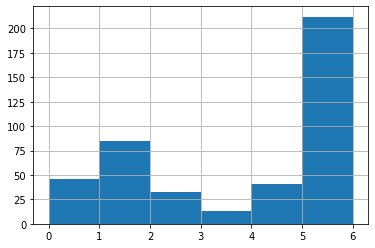

In [67]:
source = (t
    .filter(pl.col('err').is_in([0, 4]))
    .to_pandas()
)

source['total'].hist(bins = 6)

In [65]:
source = (t
    .filter(pl.col('err').is_in([0, 4]))
    .to_pandas()
)

In [66]:
import altair as alt

source = (t
    .filter(pl.col('err').is_in([0, 1]))
    .filter(pl.col('jama_compliance') == 1)
    .to_pandas()
)

alt.Chart(source).mark_bar().transform_joinaggregate(
    t='count(*)'
).transform_calculate(
    pct='1 / datum.t'
).encode(
    alt.X('total:N', title = 'Hospital price list compliance scores'),
    alt.Y('sum(pct):Q', title = 'Fraction in dataset'),
).properties(width = 400)

alt.Chart(...)

In [38]:
source = (t
    .filter(pl.col('err').is_in([0, 1]))
    .filter(pl.col('jama_compliance') == 0)
    .to_pandas()
)

alt.Chart(source).mark_bar().transform_joinaggregate(
    t='count(*)'
).transform_calculate(
    pct='1 / datum.t'
).encode(
    alt.X('total:N', title = 'Hospital price list compliance scores'),
    alt.Y('sum(pct):Q', title = 'Fraction in dataset'),
).properties(width = 400)

alt.Chart(...)

In [7]:
import openpyxl

In [32]:
%%time

read_excel('test.xlsx', 5)

CPU times: user 87.6 ms, sys: 2.52 ms, total: 90.1 ms
Wall time: 88.8 ms


'Evangelical Community HospitalTax Identification Number:  24-0795411Standard ChargesHospital Procedure Code HCPCS Code Description Code_Type Package/Line_Level Average Charge Min_Allowable_835 Max_Allowable_835 Avg_Allowable_835 Self-Pay Charge - 10% Discount AETNA ADV PLAN 250 NET 03404_Avg_Allowable AETNA AETNA CHOICE POS II_Avg_Allowable AETNA AETNA CHOICE POS II NET 00486_Avg_Allowable AETNA AETNA HEALTH NETWORK ONLY 8480 (OPEN A NET 01984_Avg_Allowable AETNA AETNA HEALTH NETWORK OPTION 8480 (OPEN NET 01984_Avg_Allowable AETNA AETNA HEALTHFUND AETNA CHOICE POS II NET 00486_Avg_Allowable AETNA AETNA HEALTHFUND AETNA OPEN ACCESS MAN NET 00486_Avg_Allowable AETNA AETNA HEALTHFUND AETNA OPEN ACCESS MAN NET 09614_Avg_Allowable AETNA AETNA HEALTHFUND OPEN ACCESS AETNA SELE NET 01669_Avg_Allowable AETNA AETNA HEALTHFUND OPEN ACCESS AETNA SELECT 8480_Avg_Allowable AETNA AETNA HEALTHFUND OPEN CHOICE PPO NET 00214_Avg_Allowable AETNA AETNA OPEN ACCESS ELECT CHOICE NET 01669_Avg_Allowable AE

In [2]:
import pandas as pd

In [4]:
%%time

pd.read_excel('test.xlsx').head()

CPU times: user 20.8 s, sys: 172 ms, total: 20.9 s
Wall time: 21 s


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 468,Unnamed: 469,Unnamed: 470,Unnamed: 471,Unnamed: 472,Unnamed: 473,Unnamed: 474,Unnamed: 475,Unnamed: 476,Unnamed: 477
0,NaN,Evangelical Community Hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Tax Identification Number: 24-0795411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Standard Charges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hospital Procedure Code,HCPCS Code,Description,Code_Type,Package/Line_Level,Average Charge,Min_Allowable_835,Max_Allowable_835,Avg_Allowable_835,Self-Pay Charge - 10% Discount,...,PA TRUST_Avg_Allowable,PMF INDUSTRIES_Avg_Allowable,PRESS ENTERPRISE_Avg_Allowable,SIGNATURE BUILDING SYSTEMS_Avg_Allowable,SMALL GROUP TPA-SPEC AND AGG_Avg_Allowable,STEVE SHANNON TIRE_Avg_Allowable,SUSQUEHANNA UNIVERSITY_Avg_Allowable,UNION COUNTY_Avg_Allowable,VERIZON_Avg_Allowable,WISE FOODS_Avg_Allowable
4,2019564,10005,Fine needle aspiration of first lesion using u...,CPT/HCPCS,Line,2640.81,70.54,3956,2018.06,2376.729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
import openpyxl

(None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [59]:
with requests.get('https://www.rwjbh.org/documents/billing/charge%20master/RWJ-New-Brunswick.xlsx', stream = True) as r:
    data = BytesIO(r.content)
    book = openpyxl.load_workbook(filename=data, read_only = True, data_only=True)

In [60]:
book